In [ ]:
import torch
from tqdm import tqdm

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained('Qwen/Qwen2.5-0.5B-Instruct').eval().to("cuda")
tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen2.5-0.5B-Instruct')

In [ ]:
# два промпта
input_text_hedgehog = '<|im_start|>system\nYou are a storyteller. Generate a story based on user message.<|im_end|>\n<|im_start|>user\nGenerate me a short story about a tiny hedgehog named Sonic.<|im_end|>\n<|im_start|>assistant\n'
input_text_json = '<|im_start|>system\nYou are a JSON machine. Generate a JSON with format {"contractor": string with normalized contractor name, "sum": decimal, "currency": string with uppercased 3-letter currency code} based on user message.<|im_end|>\n<|im_start|>user\nTransfer 100 rubles and 50 kopeck to Mike<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
# logits = model(input_ids=..., attention_mask=...).logits
# logits_for_first_batch_and_last_token = logits[0, -1]

In [ ]:
def save_to_file(content, filepath):
    """Сохраняет текст в файл"""
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(content)
    print(f"Файл сохранен: {filepath}")

#Задача 1. Greedy Decoding

In [ ]:
def greedy_decode(input_text, max_length=1000):

    # объект Encoding, в котором содержатся ids и attention_mask
    encoding = tokenizer(input_text).encodings[0]

    # токенизация encoding
    input_ids = torch.tensor([encoding.ids]).long()
    attention_mask = torch.tensor([encoding.attention_mask]).long()

    generated_ids = input_ids.clone()
    eos_token_id = 151645

    # для отображения прогресса
    progress_bar = tqdm(total=max_length, desc="Generating tokens", unit="token")

    # длина генерации превысила 1000 токенов
    for _ in range(max_length):
        with torch.no_grad():
            # модель возвращает логиты
            logits = model(input_ids=generated_ids, attention_mask=attention_mask).logits
        # Логиты для последнего токена в последовательности
        logits_for_first_batch_and_last_token = logits[0, -1, :]
        # Выбираем токен с максимальной вероятностью
        next_token_id = torch.argmax(logits_for_first_batch_and_last_token).item()

        # сгенерировался EOS-токен с ID = 151645
        if next_token_id == eos_token_id:
            progress_bar.update(1)
            progress_bar.close()
            break

        generated_ids = torch.cat([generated_ids, torch.tensor([[next_token_id]]).long()], dim=-1)
        attention_mask = torch.cat([attention_mask, torch.tensor([[1]]).long()], dim=-1)
        progress_bar.update(1)

    progress_bar.close()
    return generated_ids[0].tolist()


In [ ]:
print("Generating hedgehog story...")
hedgehog_ids = greedy_decode(input_text_hedgehog)
hedgehog_text = tokenizer.decode(hedgehog_ids, skip_special_tokens=True)
print("\nGenerated hedgehog story:")
print(hedgehog_text)

In [ ]:
save_to_file(hedgehog_text, 'hedgehog_text_1.txt')

In [ ]:
print("\nGenerating JSON...")
json_ids = greedy_decode(input_text_json)
json_text = tokenizer.decode(json_ids, skip_special_tokens=True)
print("\nGenerated JSON:")
print(json_text)

In [ ]:
save_to_file(json_text, 'json_text_1.json')

Результаты:
- Если запустить алгоритм несколько раз, то будут ли различаться генерации?

Результат генерации не будет различаться в зависимости от параметров модели (Temperature, Top_K and Top_P не применимы для greedy decoding), так как в greedy decoding всегда выбирается максимальный по вероятности токен
- Какие есть проблемы с таким подходом к генерации в случае с генерацией сказки и в случае с генерацией JSON?

В генерации текста - простота, тк выбирается наиболее подходящий вариант

В генерации JSON - может привести к ошибкам в структуре (тк они неочевидны и задаются через промт)
- Сгенерированный текст про ёжика и сгенерированный JSON.

# Задача 2. Sampling

In [ ]:
def sample_decode(input_text, max_length=1000):

    # объект Encoding, в котором содержатся ids и attention_mask
    encoding = tokenizer(input_text).encodings[0]

    # токенизация encoding
    input_ids = torch.tensor([encoding.ids]).long()
    attention_mask = torch.tensor([encoding.attention_mask]).long()

    generated_ids = input_ids.clone()
    eos_token_id = 151645

    # для отображения прогресса
    progress_bar = tqdm(total=max_length, desc="Generating tokens", unit="token")

    # длина генерации превысила 1000 токенов
    for _ in range(max_length):
        with torch.no_grad():
            # модель возвращает логиты
            logits = model(input_ids=generated_ids, attention_mask=attention_mask).logits
        # Логиты для последнего токена в последовательности
        next_token_logits = logits[0, -1, :]

        # Преобразование логитов в вероятности
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1).item()

        # Если сгенерировался EOS-токен с ID = 151645
        if next_token_id == eos_token_id:
            progress_bar.update(1)
            progress_bar.close()
            break

        generated_ids = torch.cat([generated_ids, torch.tensor([[next_token_id]]).long()], dim=-1)
        attention_mask = torch.cat([attention_mask, torch.tensor([[1]]).long()], dim=-1)
        progress_bar.update(1)

    progress_bar.close()
    return generated_ids[0].tolist()


In [ ]:
for i in range(3):

  print("Generating hedgehog story...")
  hedgehog_ids = sample_decode(input_text_hedgehog)
  hedgehog_text = tokenizer.decode(hedgehog_ids, skip_special_tokens=True)

  print("\nGenerated hedgehog story:")
  print(hedgehog_text)

  save_to_file(hedgehog_text, f'hedgehog_text_2_{i}.json')

In [ ]:
for i in range(3):

  print("\nGenerating JSON...")
  json_ids = sample_decode(input_text_json)
  json_text = tokenizer.decode(json_ids, skip_special_tokens=True)

  print("\nGenerating JSON...")
  print(json_text)

  save_to_file(json_text, f'json_text_2_{i}.json')

Результаты:
- Если запустить алгоритм несколько раз, то будут ли различаться генерации?

Результат генерации будет различаться тк выбор токена происходит случайно на основе распределения вероятностей
- Какие есть проблемы с таким подходом к генерации в случае с генерацией сказки и в случае с генерацией JSON?

В генерации текста - более творческие варианты, но стоит учитывать влияние температуры и не переборщить. В одной из генераций все ушло в несвязанный текст на другую тему.

В генерации JSON - может привести к ошибкам в структуре и нарушить строгий формат JSON. В моих генерация такого не произошло, но были логические ошибки в тексте.

- Сгенерированные тексты про ёжика и сгенерированные JSONы.

# Задача 3. Sampling meets Temperature

In [ ]:
from tqdm import tqdm

In [ ]:
def sample_decode_temp(input_text, max_length=1000, temperature = 0.5):

    # объект Encoding, в котором содержатся ids и attention_mask
    encoding = tokenizer(input_text).encodings[0]

    # токенизация encoding
    input_ids = torch.tensor([encoding.ids]).long()
    attention_mask = torch.tensor([encoding.attention_mask]).long()

    generated_ids = input_ids.clone()
    eos_token_id = 151645

    # для отображения прогресса
    progress_bar = tqdm(total=max_length, desc="Generating tokens", unit="token")

    # длина генерации превысила 1000 токенов
    for _ in range(max_length):
        with torch.no_grad():
            # модель возвращает логиты
            logits = model(input_ids=generated_ids.to("cuda"), attention_mask=attention_mask.to("cuda")).logits.detach()
        # Логиты для последнего токена в последовательности
        next_token_logits = logits[0, -1, :]

        # Настройка температуры
        next_token_logits = next_token_logits / temperature

        # Преобразование логитов в вероятности
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1).item()

        # Если сгенерировался EOS-токен с ID = 151645
        if next_token_id == eos_token_id:
            progress_bar.update(1)
            progress_bar.close()
            break

        generated_ids = torch.cat([generated_ids, torch.tensor([[next_token_id]]).long()], dim=-1)
        attention_mask = torch.cat([attention_mask, torch.tensor([[1]]).long()], dim=-1)
        progress_bar.update(1)

    progress_bar.close()
    return generated_ids[0].cpu().tolist()


In [ ]:
temperature = [0.001, 0.1, 0.5, 1.0, 10.0]

In [ ]:
for temp in temperature:

  print("Generating hedgehog story...")
  hedgehog_ids = sample_decode_temp(input_text_hedgehog, temperature = temp)
  hedgehog_text = tokenizer.decode(hedgehog_ids, skip_special_tokens=True)

  print("\nGenerated hedgehog story:")
  print(hedgehog_text)

  save_to_file(hedgehog_text, f'hedgehog_text_3_{temp}.json')

In [ ]:
for temp in temperature:

  print("\nGenerating JSON...")
  json_ids = sample_decode_temp(input_text_json, temperature = temp)
  json_text = tokenizer.decode(json_ids, skip_special_tokens=True)

  print("\nGenerating JSON...")
  print(json_text)

  save_to_file(json_text, f'json_text_3_{temp}.json')

Результаты:
- Как отличаются генерации с температурами: 0.001, 0.1, 0.5, 1.0, 10.0?

Дефолтное значение моделей обычно окол 0.5. При значениях ниже генерации похожи между собой и не отличаются оригинальностью. При значениях выше - получает плохо связанный текст и очень плохая структура файла.

при первых двух згначениях (меньше дефолтных) генерятся очень похожие между собой результаты
при 10 (что значительно превышает дефолтное) генерится "мусор", тк модель слишком бредит

- Есть ли какая-то закономерность при уменьшении/увеличении температуры?

Чем выше температура - тем больше модель "бредит", выбирая более непредсказуемые токены
- Для каких задач какая температура лучше?

Для творческих задач (сказки, человекоподобный ответ) - температура повыше

Для задач, где важна структура - например код, конкретная фраза опредленного формата, то лучше брать значения меньше

- Приложить сгенерированные текста про ёжика и сгенерированные JSON, по одному тексту про ёжика и одному JSON для каждой температуры из 0.001, 0.1, 0.5, 1.0, 10.0

# Задача 4. Nucleus Sampling

Как прошлая задача, но нужно сэмплировать не из всего распределения, а только среди самых вероятных токенов.

Как это сделать:

- Имеем распределение вероятностей по токенам, полученное от модели с применённой температурой.
- Оставляем только самые вероятные токены, кумулятивная вероятность которых не превышает top_p.
- Остальные выбрасываем.
- Если так получилось, что самый вероятный токен уже имеет вероятность больше, чем top_p, - оставляем только его.
- Так как вектор из вероятностей теперь не совсем распределение (значения не суммируются в 1), то отмасштабируем каждую вероятность, разделив её на сумму всех вероятностей.
- Теперь значения суммируется в 1.
- Смотрите формулу #3 в статье.
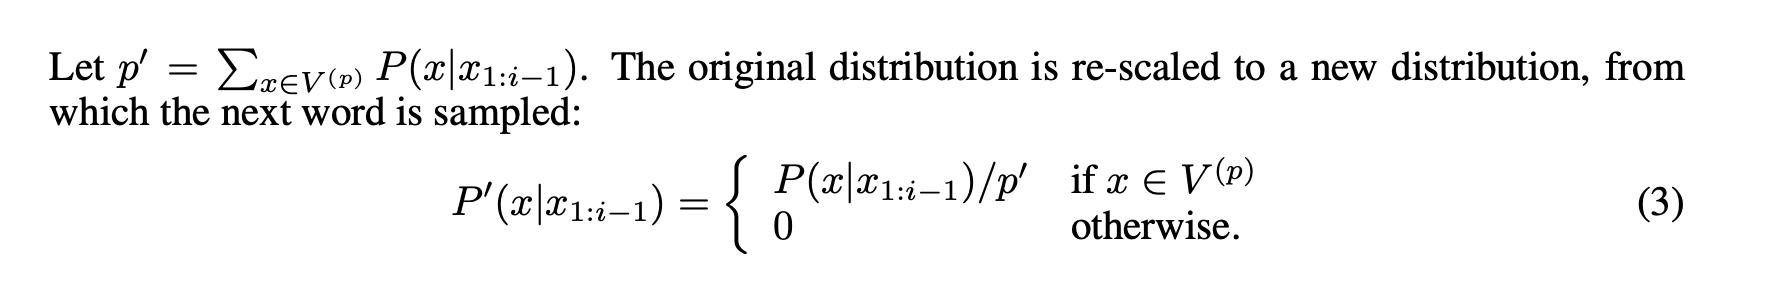
- Выполняем сэмплирование.

In [ ]:
def nucleus_sample(input_text, max_length=1000, temperature = 0.5, top_p = 1.0):

    # объект Encoding, в котором содержатся ids и attention_mask
    encoding = tokenizer(input_text).encodings[0]

    # токенизация encoding
    input_ids = torch.tensor([encoding.ids]).long()
    attention_mask = torch.tensor([encoding.attention_mask]).long()

    generated_ids = input_ids.clone()
    eos_token_id = 151645

    # для отображения прогресса
    progress_bar = tqdm(total=max_length, desc="Generating tokens", unit="token")

    # длина генерации превысила 1000 токенов
    for _ in range(max_length):
        with torch.no_grad():
            # модель возвращает логиты
            logits = model(input_ids=generated_ids.to("cuda"), attention_mask=attention_mask.to("cuda")).logits.detach()
        # Логиты для последнего токена в последовательности
        next_token_logits = logits[0, -1, :]

        # Настройка температуры
        next_token_logits = next_token_logits / temperature
        # Преобразование логитов в вероятности
        probs = torch.softmax(next_token_logits, dim=-1)

        #
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

        # минимальный набор токенов, покрывающий top_p
        mask = cumulative_probs >= top_p
        if mask.any():
            cutoff = torch.argmax(mask.to(torch.long))
        else:
            cutoff = sorted_probs.size(-1) - 1

        # обнуление остальных
        sorted_probs[(cutoff+1):] = 0.0
        # исходный порядок токенов
        probs.scatter_(-1, sorted_indices, sorted_probs)
        # нормализация
        probs.div_(probs.sum())
        #

        next_token_id = torch.multinomial(probs, num_samples=1).item()

        # Если сгенерировался EOS-токен с ID = 151645
        if next_token_id == eos_token_id:
            progress_bar.update(1)
            progress_bar.close()
            break

        generated_ids = torch.cat([generated_ids, torch.tensor([[next_token_id]]).long()], dim=-1)
        attention_mask = torch.cat([attention_mask, torch.tensor([[1]]).long()], dim=-1)
        progress_bar.update(1)

    progress_bar.close()
    return generated_ids[0].cpu().tolist()


In [ ]:
temperature = [1, 0.5]
top_p = [0.9, 0.15]

In [ ]:
for temp in temperature:
  for p in top_p:

    print("Generating hedgehog story...")
    hedgehog_ids = nucleus_sample(input_text_hedgehog, temperature = temp, top_p = p)
    hedgehog_text = tokenizer.decode(hedgehog_ids, skip_special_tokens=True)

    print("\nGenerated hedgehog story:")
    print(hedgehog_text)

    save_to_file(hedgehog_text, f'hedgehog_text_4_{temp}_{p}.json')

In [ ]:
for temp in temperature:
  for p in top_p:

    print("\nGenerating JSON...")
    json_ids = nucleus_sample(input_text_json, temperature = temp, top_p = p)
    json_text = tokenizer.decode(json_ids, skip_special_tokens=True)

    print("\nGenerating JSON...")
    print(json_text)

    save_to_file(json_text, f'json_text_4_{temp}_{p}.json')

Результаты:
- Как отличаются генерации с
1.   temperature=1, top_p=0.9; - генерация разнообразная за счет значения температуры, но исключает очень редкие токены, что спасает от генерации мусора
2.   temperature=1, top_p=0.15 - за счет жесткого ограничения top/-p текст даже с такой температурой становится более предсказуемым
3.   temperature=0.5, top_p=0.9 - за счет высокого значения top_p делает тексты более разнообращзными даже при небольшом значении температуры
4.   temperature=0.5, top_p=0.15? - очень шаблонный текст за счет маленьких значений обоих параматеров

- Помог ли nucleus sampling исправить какие-то проблемы, которые были при простом сэмплировании с температурой?

Исправил проблему генерации мусора, умеьшая влияния одного параметра на итоговый текст

- Приложить сгенерированные текста про ёжика и сгенерированные JSON, по одному тексту про ёжика и одному JSON для каждого набора параметров

# Задача 5. Early-Stopped Beam Search

In [ ]:
import torch.nn.functional as F

In [ ]:
def stop_beam_search(input_text, max_length=1000, num_beams=4, length_penalty=1.0):

    # объект Encoding, в котором содержатся ids и attention_mask
    encoding = tokenizer(input_text).encodings[0]

    # токенизация encoding
    input_ids = torch.tensor([encoding.ids]).long()
    attention_mask = torch.tensor([encoding.attention_mask]).long()

    generated_ids = input_ids.clone()
    eos_token_id = 151645

    # кандидаты
    unfinished_candidates = [{
        'tokens': input_ids,
        'attention_mask': attention_mask,
        'score': 0.0
    }]
    finished_candidates = []

    # для отображения прогресса
    progress_bar = tqdm(total=max_length, desc="Generating tokens", unit="token")

    # длина генерации превысила 1000 токенов
    for _ in range(max_length):
        all_candidates = []

        for candidate in unfinished_candidates:
            tokens = candidate['tokens']
            att_mask = candidate['attention_mask']
            score = candidate['score']

            with torch.no_grad():
                # модель возвращает логиты
                logits = model(input_ids=tokens.to("cuda"), attention_mask=att_mask.to("cuda")).logits.detach()
            # Логиты для последнего токена в последовательности
            last_token_logits = logits[0, -1, :]
            log_probs = F.log_softmax(last_token_logits, dim=-1)

            # num_beams самых вероятных токенов
            top_log_probs, top_token_ids = torch.topk(log_probs, num_beams)

            for log_prob, token_id in zip(top_log_probs.tolist(), top_token_ids.tolist()):
              new_tokens = torch.cat([tokens, torch.tensor([[token_id]]).long()], dim=-1)
              new_attention_mask = torch.cat([att_mask, torch.tensor([[1]]).long()], dim=-1)

              new_score = score + log_prob

              candidate_obj = {
                    'tokens': new_tokens.cpu(),
                    'attention_mask': new_attention_mask.cpu(),
                    'score': new_score
              }

              # сгенерировался EOS-токен с ID = 151645
              if token_id == eos_token_id:
                finished_candidates.append(candidate_obj)
              else:
                all_candidates.append(candidate_obj)


        # законченные кандидаты - num_beams, добавляем их и удаляем из незаконченных
        all_candidates = sorted(all_candidates, key=lambda c: c['score'], reverse=True)
        unfinished_candidates = all_candidates[:num_beams]

        # есть законченные кандидаты - добавляем
        finished_candidates = sorted(finished_candidates, key=lambda c: c['score'] / (c['tokens'].shape[-1] ** length_penalty), reverse=True)
        if len(finished_candidates) >= num_beams:
            progress_bar.update(1)
            break

        # нет незаконченных кандидатов
        if len(unfinished_candidates) == 0:
            progress_bar.update(1)
            break

        progress_bar.update(1)

    progress_bar.close()

    # законченные кандидаты: лучший по формуле ранжирования
    if finished_candidates:
        best_candidate = max(
            finished_candidates,
            key=lambda c: c['score'] / (c['tokens'].shape[-1] ** length_penalty)
        )
    else:
        # лучший из незаконченных
        best_candidate = max(
            unfinished_candidates,
            key=lambda c: c['score'] / (c['tokens'].shape[-1] ** length_penalty)
        )

    return best_candidate['tokens'][0].cpu().tolist()

In [ ]:
arr_stop_beam_search = [ (1, 1.0),
                          (4, 1.0),
                          (4, 0.5),
                          (4, 2.0),
                          (8, 1.0) ]

In [ ]:
for nb, lp in arr_stop_beam_search:

    print("Generating hedgehog story...")
    hedgehog_ids = stop_beam_search(input_text_hedgehog, num_beams = nb,length_penalty= lp)
    hedgehog_text = tokenizer.decode(hedgehog_ids, skip_special_tokens=True)

    print("\nGenerated hedgehog story:")
    print(hedgehog_text)

    save_to_file(hedgehog_text, f'hedgehog_text_5_{nb}_{lp}.json')

In [ ]:
for nb, lp in arr_stop_beam_search:

    print("\nGenerating JSON...")
    json_ids = stop_beam_search(input_text_json, num_beams = nb,length_penalty= lp)
    json_text = tokenizer.decode(json_ids, skip_special_tokens=True)

    print("\nGenerating JSON...")
    print(json_text)

    save_to_file(json_text, f'json_text_5_{nb}_{lp}.json')

Результаты:
- Как отличаются результаты с
1. num_beams=1, length_penalty=1.0 - greedy decoding
2. num_beams=4, length_penalty=1.0 - разнообразные варинаты за счет рассматорения длинных цепочек, длина последовательности учитывается линейно, без сильного смещения в сторону коротких или длинных вариантов
3. num_beams=4, length_penalty=0.5 - короткие варианты становятся более предпочтительными из за length_penalty меньше 1
3. num_beams=4, length_penalty=0.5 - короткие варианты становятся более предпочтительными из за length_penalty меньше 1
4. num_beams=4, length_penalty=2.0 - более развернутые и длинные варианты за счет  больше 1
5. num_beams=8, length_penalty=1.0?

- Есть ли какая-то закономерность при увеличении/уменьшении num_beams и length_penalty?

при увеличении num_beams рассматриваются более длинные цепочки даже если первый токен был менее вероятен, при уменьшении - берется ниболее веротяные токены из первых комбинаций
чем больше length_penalty тем длиннее и подробнее будет итоговый ответ
- Помог ли текущий способ исправить проблемы, которые возникли с Greedy Decoding?
- Для какого рода задач beam search подходит больше, чем nucleus sampling?

Да, за счет рассмотрени цепочек и учитывания влияния выбора последующих токенов
- Приложить сгенерированные текста про ёжика и сгенерированные JSON, по одному тексту про ёжика и одному JSON для каждого набора параметров